In [1]:
import pandas as pd


proteome = pd.read_csv("../data/human_proteome.gz")
proteome["trivname"] = proteome["trivname"].apply(lambda x: x.split("_")[0])
data = pd.read_csv("../data/enzymes/processed.csv")
design = pd.read_csv("../data/enzymes/design.csv")
data.head(3)

,Protein Accession,Peptide,cht1,cht2,cht3,cht4,cht5,cht6,cht7,cht8,...,trp1,trp2,trp3,trp4,trp5,trp6,trp7,trp8,trp9,trp10
0,AHNK,SKGHYEVTGSDDETGKLQGSGVSLASK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,19.965362,19.859677,19.536494,19.788626,0.000000,19.147533,20.026885,20.284101,20.085633
1,AHNK,HELTEISNVDVETQSGK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.106965,22.588568,22.525830,22.169102,22.290387,21.455331,21.660012,22.394694,22.893766,22.956792
2,AHNK,IKGDVPSVGLEGPDVDLQGPEAK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.469734,23.000446,22.978793,22.668671,22.494824,21.885541,21.668130,22.948707,23.091940,23.230696


In [2]:
proteins = pd.read_csv("../data/enzymes/proteins.csv")
proteins = proteins[proteins["#Peptides"] > 30]
proteins["pep per mass"] = proteins["#Peptides"] / proteins["Avg. Mass"] 
proteins = proteins.sort_values("pep per mass", ascending=False)["Accession"][0:20].apply(lambda x: x.split("|")[1].split("_")[0])
proteins

5      H2B1C
4      H2B1M
11     H2B1K
6      H2B2E
13     H2B1J
20     H2B1L
34     H2A1H
33     H2A1J
44     H2A2A
35      H2A1
41      H2AJ
40     H2A1D
47     H2A1C
51      H2A3
52     H2A1B
48     H2A2B
46      H2AX
64        H4
28     H2B3B
113     CH10
Name: Accession, dtype: object

In [3]:
import numpy as np


data = data[data["Protein Accession"].isin(proteins)]
samples = design["sample"]
data_dict = {}  # sample: {protein: {peptide:amount}}

for sample in samples:
    protein_dict = {}
    for protein in data["Protein Accession"].unique():
        sample_data = (
            data[["Protein Accession", "Peptide", sample]]
            .replace(0, np.nan)
            .dropna(subset=[sample])
        )
        sample_data = sample_data[sample_data["Protein Accession"] == protein]
        peptide_dict = {}
        # insert the original protein sequence
        try:
            protein_sequence = proteome[proteome["trivname"].isin([f"{protein}_HUMAN", protein])][
                "seq"
            ].values[0]
        except:
            print(protein)
            continue
        peptide_dict[protein_sequence] = (
            1  # probably want to replace this with some reasonable number
        )
        for i, row in sample_data.iterrows():
            peptide = row["Peptide"]
            abundance = row[sample]
            peptide_dict[peptide] = abundance
        protein_dict[protein] = peptide_dict
    data_dict[sample] = protein_dict
data_dict

{'cht1': {'H2B1M': {'MPEPVKSAPVPKKGSKKAINKAQKKDGKKRKRSRKESYSVYVYKVLKQVHPDTGISSKAMGIMNSFVNDIFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVTKYTSSK': 1,
   'PGELAKHAVSEGTKAVTKY': 20.5162425021794,
   'NKRSTITSREIQTAVR': 19.956597363815696,
   'LLPGELAKHAVSEGTK': 20.569688757408205,
   'AKHAVSEGTKAVTKY': 25.023395321195554,
   'ERIAGEASRLAHY': 19.99865653412532,
   'HAVSEGTKAVTKY': 21.73268582754872,
   'KQVHPDTGISSKAM': 26.993668689010992,
   'RLLLPGELAKH': 21.68097411496493,
   'PGELAKHAVSEGTKAVT': 19.465630171745293,
   'PEPVKSAPVPK': 21.689914391260054,
   'VNDIFERIAGEAS': 21.648120554373467,
   'NKRSTITSREIQTAVRL': 23.619972757721637,
   'AVSEGTKAVTKY': 26.160579606336025,
   'LLPGELAKHAVSEGTKAVTKY': 24.579803899097808,
   'KRSTITSREIQTAVRL': 19.39332760632584,
   'ITSREIQTAVRL': 21.14488474139517,
   'SEGTKAVTKY': 22.487556463573075,
   'VRLLLPGEL': 19.97631239054857,
   'LLPGELAKHAVSEGTKAV': 20.038050899794158,
   'QVHPDTGISSKAM': 20.481484122946128,
   'TITSREIQTAVRL': 23.091843

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


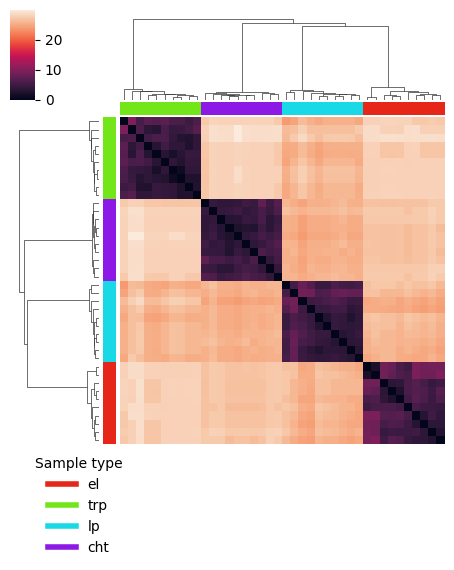

In [4]:
from disassembly.util import KL
from disassembly.estimate_parameters import compare

# data_dict  sample:protein:peptides

protein = "H2B1C"

comparisons = {}
for i in data_dict.keys():
    if protein in data_dict[i].keys():
        peptidome_comp_1 = data_dict[i][protein]
        comparisons[i] = {}
        for j in data_dict.keys():
            if protein in data_dict[j].keys():
                peptidome_comp_2 = data_dict[j][protein]
                p, q = compare(peptidome_comp_1, peptidome_comp_2)
                err = KL(p, q) + KL(q, p)
                comparisons[i][j] = err

import pandas as pd

comps_df = pd.DataFrame(comparisons)

import seaborn as sns
from matplotlib.lines import Line2D

labels = design["group"]
lut = dict(zip(set(labels), sns.hls_palette(len(set(labels)), l=0.5, s=0.8)))
row_colors = design["group"].map(lut)

g = sns.clustermap(
    comps_df,
    figsize=(5, 5),
    row_colors=row_colors.to_numpy(),
    col_colors=row_colors.to_numpy(),
)
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
legend_elements = [
    Line2D([0], [0], color=c, lw=4, label=l) for l, c in zip(lut.keys(), lut.values())
]
g.ax_heatmap.legend(
    frameon=False,
    handles=legend_elements,
    loc="upper left",
    bbox_to_anchor=(-0.3, 0),
    title="Sample type",
)

In [5]:
from disassembly.estimate_weights_gd import WeightEstimatorGD
from disassembly.disassembly import get_disassembly_indexes_mc, get_disassembly

results = {}  # dict of sample: protein_disassembly
wegd = WeightEstimatorGD(lr=.1, n_iterations=250)
n_pep = {}
average_di = {}

for sample, protein_dict in data_dict.items():
    print(f"\n ---{sample}--- \n")
    protein_disassembly = {}  # dict of protein: disassembly
    protein_n_pep = {}
    protein_di = {}
    for protein, peptidome in protein_dict.items():
        graph = wegd.run(peptidome, verbose=True)
        di = get_disassembly_indexes_mc(graph, N_particles=10000)
        disassembly = get_disassembly(peptidome, di, exp=True)
        protein_disassembly[protein] = disassembly
        protein_n_pep[protein] = len(peptidome.values())
        protein_di[protein] = np.mean(list(di.values()))
    results[sample] = protein_disassembly
    n_pep[sample] = protein_n_pep
    average_di[sample] = protein_di


 ---cht1--- 

 249 / 250 | 0.14, kl: 0.14, reg: 0.00  | nz: 190 | 
 Averaged DI: 2.13
 249 / 250 | 0.07, kl: 0.07, reg: 0.00  | nz: 189 | 
 Averaged DI: 2.22
 249 / 250 | 0.10, kl: 0.10, reg: 0.00  | nz: 189 | 
 Averaged DI: 2.10
 249 / 250 | 0.12, kl: 0.12, reg: 0.00  | nz: 189 | 
 Averaged DI: 2.15
 249 / 250 | 0.11, kl: 0.11, reg: 0.00  | nz: 189 | 
 Averaged DI: 2.15
 249 / 250 | 0.09, kl: 0.09, reg: 0.00  | nz: 183 | 
 Averaged DI: 2.06
 249 / 250 | 0.02, kl: 0.02, reg: 0.00  | nz: 90 | 
 Averaged DI: 1.77
 249 / 250 | 0.15, kl: 0.15, reg: 0.00  | nz: 120 | 
 Averaged DI: 1.96
 249 / 250 | 0.10, kl: 0.10, reg: 0.00  | nz: 120 | 
 Averaged DI: 1.94
 249 / 250 | 0.07, kl: 0.07, reg: 0.00  | nz: 120 | 
 Averaged DI: 2.00
 249 / 250 | 0.10, kl: 0.10, reg: 0.00  | nz: 113 | 
 Averaged DI: 1.98
 249 / 250 | 0.07, kl: 0.07, reg: 0.00  | nz: 97 | 
 Averaged DI: 1.82
 249 / 250 | 0.11, kl: 0.11, reg: 0.00  | nz: 116 | 
 Averaged DI: 1.97
 249 / 250 | 0.08, kl: 0.08, reg: 0.00  | nz: 62 | 

KeyboardInterrupt: 

In [ ]:
n_pep_df = pd.DataFrame(n_pep).stack().reset_index().rename(columns={"level_0":"protein", "level_1":"sample", 0:"n_pep"})
results_df = pd.DataFrame(results).stack().reset_index().rename(columns={"level_0":"protein", "level_1":"sample", 0:"d"})
average_di_df = pd.DataFrame(average_di).stack().reset_index().rename(columns={"level_0":"protein", "level_1":"sample", 0:"di"})
average_di_df.head(3)

,protein,sample,di
0,H2B1M,cht1,2.156235
1,H2B1M,cht2,2.249774
2,H2B1M,cht3,2.227047


In [ ]:
n_pep_df = pd.DataFrame(n_pep).stack().reset_index().rename(columns={"level_0":"protein", "level_1":"sample", 0:"npep"})
results_df = pd.DataFrame(results).stack().reset_index().rename(columns={"level_0":"protein", "level_1":"sample", 0:"d"})
results_df = results_df.merge(n_pep_df).merge(design).merge(average_di_df)

<Axes: xlabel='npep', ylabel='di'>

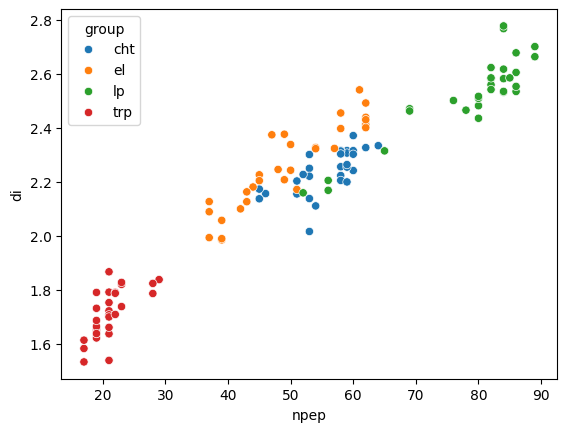

In [ ]:
sns.scatterplot(results_df, x="npep", y="di", hue="group")

<Axes: xlabel='protein', ylabel='d'>

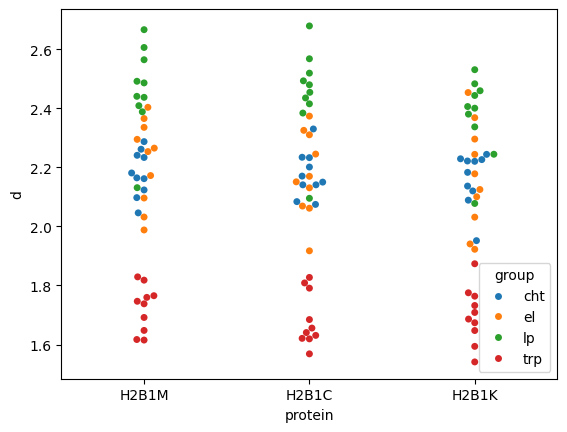

In [ ]:
sns.swarmplot(
    results_df, x="protein", y="d", hue="group"
)

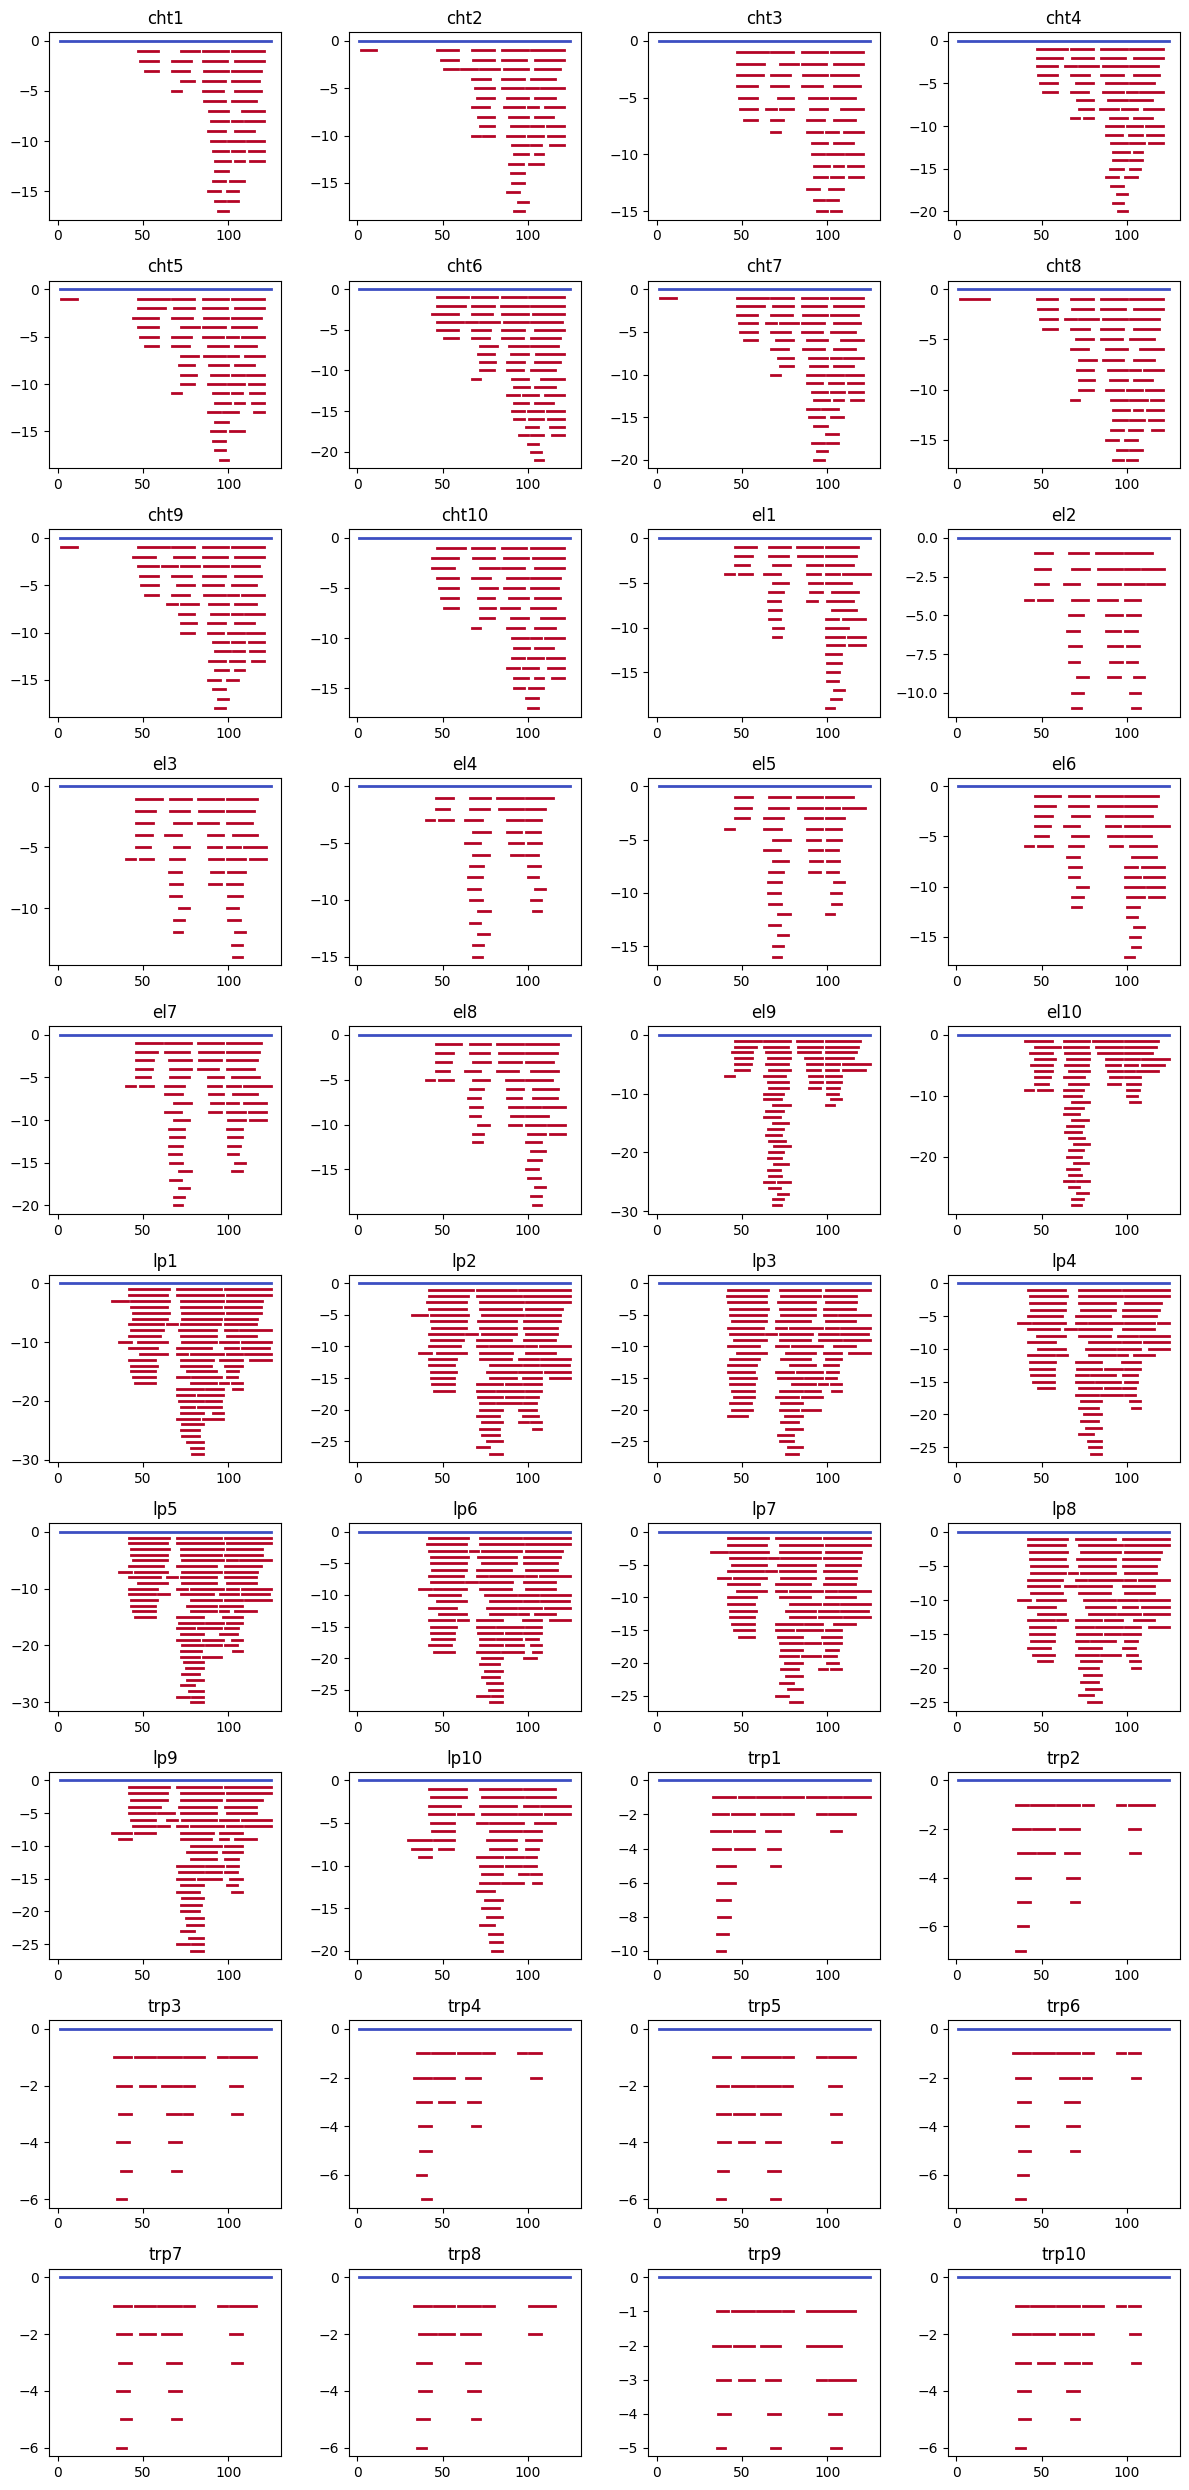

In [ ]:
from disassembly.util import plot_peptidome
import matplotlib.pyplot as plt

fig, axs = plt.subplots(
    10,
    4,
    figsize=(12, 25),
)
for i, ax in zip(range(len(samples)), axs.ravel()):

    ax.set_title(samples[i])

    plot_peptidome(
        proteome[proteome["trivname"] == protein]["seq"].values[0],
        data_dict[samples[i]][protein],
        ax,
    )
plt.tight_layout()

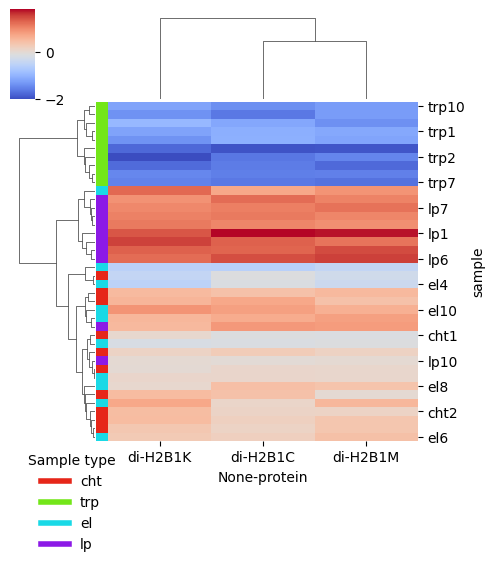

In [ ]:
import seaborn as sns
import numpy as np

heatmap_df = results_df[["sample", "di", "protein"]]
heatmap_df = heatmap_df.pivot(columns="protein", index="sample")

g = sns.clustermap(
    heatmap_df,
    cmap="coolwarm",
    figsize=(5, 5),
    row_colors=row_colors.to_numpy(),
    z_score=True,
)

g.ax_heatmap.legend(
    frameon=False,
    handles=legend_elements,
    loc="upper left",
    bbox_to_anchor=(-0.3, 0),
    title="Sample type",
)

In [ ]:

heatmap_df = results_df[["sample", "npep", "protein"]]
heatmap_df = heatmap_df.pivot(columns="protein", index="sample")

g = sns.clustermap(
    heatmap_df,
    cmap="coolwarm",
    figsize=(5, 5),
    row_colors=row_colors.to_numpy(),
    z_score=True,
)

g.ax_heatmap.legend(
    frameon=False,
    handles=legend_elements,
    loc="upper left",
    bbox_to_anchor=(-0.3, 0),
    title="Sample type",
)